<a href="https://colab.research.google.com/github/ShishirGTM32/Pytorch-Practice/blob/main/Neural_Style_Transfer_(NST)_with_PyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [3]:
#install Dependencies
!pip install torch torchvision matplotlib pillow


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 98.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 74.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 54.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 6.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 82.6 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

In [5]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import models, transforms
from PIL import Image
import matplotlib.pyplot as plt
%matplotlib inline

In [40]:
import requests

def download_image(url, filename):
    response = requests.get(url, stream=True)
    if response.status_code == 200:
        with open(filename, "wb") as file:
            for chunk in response.iter_content(1024):
                file.write(chunk)
        print(f"{filename} downloaded successfully!")
    else:
        print(f"Failed to download {filename}: {response.status_code}")

# Content Image (Landscape from Unsplash)
content_url = "https://images.unsplash.com/photo-1506748686214-e9df14d4d9d0"

# Style Image (Abstract from Unsplash)
style_url = "https://images.unsplash.com/photo-1496977297625-91bb56e3a8d0"

download_image(style_url, "style.jpg")


Failed to download style.jpg: 404


In [41]:
import os

# Check file sizes
print("Content image size:", os.path.getsize("content.jpg"))
print("Style image size:", os.path.getsize("style.jpg"))


Content image size: 2302023
Style image size: 302845


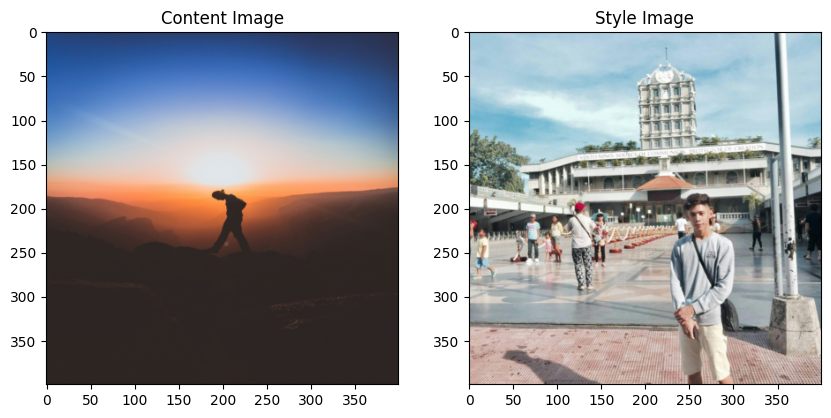

In [43]:
# Image loader function
def load_image(img_path, max_size=400):
    image = Image.open(img_path).convert("RGB")

    # Resize image
    size = max(image.size)
    if size > max_size:
        size = max_size

    transform = transforms.Compose([
        transforms.Resize((size, size)),
        transforms.ToTensor()
    ])

    image = transform(image).unsqueeze(0)  # Add batch dimension
    return image

# Load content and style images
content_img = load_image("content.jpg")
style_img = load_image("style.jpg")

# Display images
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(content_img.squeeze().permute(1, 2, 0))
plt.title("Content Image")

plt.subplot(1, 2, 2)
plt.imshow(style_img.squeeze().permute(1, 2, 0))
plt.title("Style Image")

plt.show()


In [55]:
vgg = models.vgg16(pretrained=True).features.to(device).eval()  # Extract feature layers only


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
vgg.to(device)



/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/vgg16-397923af.pth" to /root/.cache/torch/hub/checkpoints/vgg16-397923af.pth
100%|██████████| 528M/528M [00:05<00:00, 104MB/s] 


Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (17): Conv2d(256, 512, kernel_si

In [62]:
content_layers = ["conv4_2"]
style_layers = ["conv1_1", "conv2_1", "conv3_1", "conv4_1", "conv5_1"]

class VGGFeatures(nn.Module):
    def __init__(self, model, content_layers, style_layers):
        super(VGGFeatures, self).__init__()
        self.model = model
        self.content_layers = content_layers
        self.style_layers = style_layers
        self.layers = self.content_layers + self.style_layers

    def forward(self, x):
        features = {}
        layer_names = [
            'conv1_1', 'conv1_2', 'conv2_1', 'conv2_2', 'conv3_1', 'conv3_2', 'conv3_3',
            'conv4_1', 'conv4_2', 'conv4_3', 'conv5_1', 'conv5_2', 'conv5_3'
        ]

        x = x
        for i, layer in enumerate(self.model):
            x = layer(x)
            if i < len(layer_names):
                layer_name = layer_names[i]
                if layer_name in self.layers:
                    features[layer_name] = x

        return features

# Instantiate the feature extractor with the VGG16 model and layers
feature_extractor = VGGFeatures(vgg, content_layers, style_layers).to(device)

In [60]:
def content_loss(content_feature, generated_feature):
    return torch.mean((content_feature - generated_feature) ** 2)

def gram_matrix(tensor):
    _, c, h, w = tensor.shape
    tensor = tensor.view(c, h * w)
    return torch.mm(tensor, tensor.t())

def style_loss(style_feature, generated_feature):
    gram_style = gram_matrix(style_feature)
    gram_generated = gram_matrix(generated_feature)
    return torch.mean((gram_style - gram_generated) ** 2)


Epoch 0/500 - Loss: 376061229531136.0000
Epoch 50/500 - Loss: 16860939550720.0000
Epoch 100/500 - Loss: 8977620402176.0000
Epoch 150/500 - Loss: 6388429357056.0000
Epoch 200/500 - Loss: 5038033862656.0000
Epoch 250/500 - Loss: 4167651295232.0000
Epoch 300/500 - Loss: 3532994379776.0000
Epoch 350/500 - Loss: 3035154350080.0000
Epoch 400/500 - Loss: 2628853432320.0000
Epoch 450/500 - Loss: 2292139950080.0000


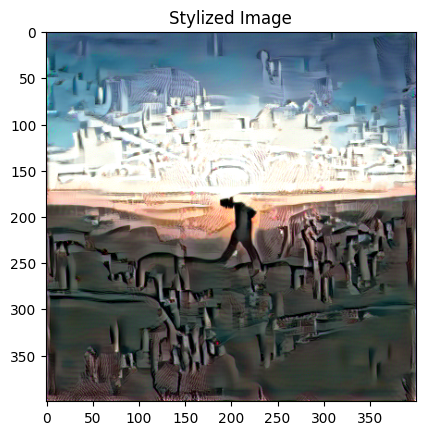

In [61]:
# Initialize generated image as a copy of the content image
generated_img = content_img.clone().requires_grad_(True).to(device)

# Define optimizer
optimizer = optim.Adam([generated_img], lr=0.01)

# Define weights for losses
content_weight = 1e4
style_weight = 1e6

# Training loop
epochs = 500
for epoch in range(epochs):
    optimizer.zero_grad()

    # Extract features
    content_features = feature_extractor(content_img.to(device))
    style_features = feature_extractor(style_img.to(device))
    generated_features = feature_extractor(generated_img)

    # Compute losses
    c_loss = content_loss(content_features["conv4_2"], generated_features["conv4_2"])
    s_loss = sum(style_loss(style_features[layer], generated_features[layer]) for layer in style_layers)

    loss = content_weight * c_loss + style_weight * s_loss

    # Backpropagate and update image
    loss.backward()
    optimizer.step()

    # Print progress
    if epoch % 50 == 0:
        print(f"Epoch {epoch}/{epochs} - Loss: {loss.item():.4f}")

# Convert tensor to image
def tensor_to_image(tensor):
    image = tensor.cpu().detach().squeeze().permute(1, 2, 0)
    image = image.clamp(0, 1)
    return image

# Display the final stylized image
plt.imshow(tensor_to_image(generated_img))
plt.title("Stylized Image")
plt.show()
